In [22]:
from dask.distributed import Client, LocalCluster
# import geopandas as gpd
# import networkx as nx
# from itertools import combinations
import dask
import numpy as np
from dask import delayed, dataframe as dd
import dask.array as da
import bokeh
import geopandas as gpd
from dask_ml.cluster import KMeans
import dask_geopandas as dgpd
from tqdm.notebook import tqdm
import pandas as pd
from shapely import Polygon
import json
import os
import glob

In [23]:
tessellation = gpd.read_parquet("./out/singapore/tessellation.pq")

<Axes: >

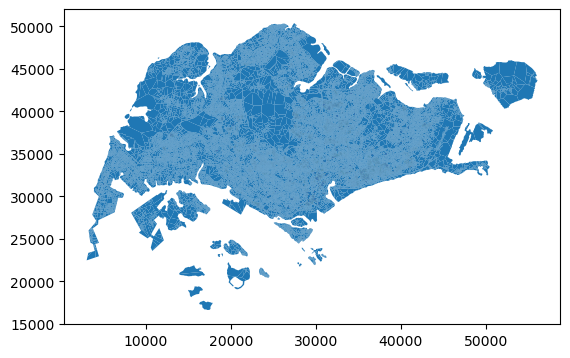

In [24]:
tessellation.plot()

In [25]:
def duplicates(tessellation):
    # Check for duplicates based on UID
    duplicates = tessellation[tessellation.duplicated(subset='uID', keep=False)]

    # duplicates.to_file( "./out/" + place + 'errors.shp', driver='ESRI Shapefile')

    # Print the duplicate rows
    if len(duplicates) > 0:
        raise Exception("Tesselation: Duplicate UID entries:")
    elif (tessellation["uID"].isnull().values.any()):
        raise Exception("uID column include invalid entries")
    else:
        return 0

duplicates(tessellation)

0

In [11]:
# Init graph object
# G = nx.Graph()

In [12]:
# uID_list = tessellation["uID"].unique()

# for uid in np.sort(uID_list):
#     G.add_node(uid)

In [13]:
# Load the tessellation as a Dask dataframe
# tessellation_dd = dd.from_pandas(tessellation, npartitions=24)

In [14]:
# # define a function to process every pair
# def process_pair(pair):
#     # do something with the pair of rows

#     out = (int(pair[0]["uID"]), int(pair[1]["uID"]))
#     print(out)
#     return out
#     # if x_geom.touches(y_geom):
#     #     G.add_edge(pair[0]["uID"], pair[1]["uID"])
#     # elif x_geom.intersects(y_geom):
#     #     G.add_edge(pair[0]["uID"], pair[1]["uID"])

# pairs = []

# # iterate through every pair of rows in the Dask dataframe
# pairs = tessellation_dd.compute().index.tolist()
# for i, j in combinations(pairs, 2):
#     # get the rows of the two indices
#     row1 = tessellation_dd.loc[i].compute()
#     row2 = tessellation_dd.loc[j].compute()

#     # do something with the pair of geometries
#     pair = process_pair((row1, row2))
    
#     # append the pair to the list
#     pairs.append(pair)

In [26]:
Daskcluster = LocalCluster(threads_per_worker=2,
                n_workers=8, memory_limit='100GB')

client = Client(Daskcluster)
client

/home/virgilxw/miniconda3/lib/python3.10/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46349 instead
  warnings.warn(
2023-03-25 01:28:40,236 - distributed.worker_memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 15.58 GiB
2023-03-25 01:28:40,238 - distributed.worker_memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 15.58 GiB
2023-03-25 01:28:40,241 - distributed.worker_memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 15.58 GiB
2023-03-25 01:28:40,245 - distributed.worker_memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 15.58 GiB
2023-03-25 01:28:40,248 - distributed.worker_memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 15.58 GiB
2023-03-25 01:28:40,251 - distributed.worker_memory - WARNING - Ig

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:46349/status,
Dashboard: http://127.0.0.1:46349/status,Workers: 8
Total threads: 16,Total memory: 124.66 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36069,Workers: 8
Dashboard: http://127.0.0.1:46349/status,Total threads: 16
Started: Just now,Total memory: 124.66 GiB
Comm: tcp://127.0.0.1:35679,Total threads: 2
Dashboard: http://127.0.0.1:35439/status,Memory: 15.58 GiB
Nanny: tcp://127.0.0.1:33205,


In [27]:
# Assuming 'tessellation' is a GeoDataFrame with a 'geometry' column
# Convert the GeoDataFrame to a Dask GeoDataFrame
dask_tessellation = dd.from_pandas(tessellation, npartitions=16)

In [28]:
x_coords = dask_tessellation.geometry.centroid.x.to_dask_array(lengths=True)
y_coords = dask_tessellation.geometry.centroid.y.to_dask_array(lengths=True)

# Concatenate x and y coordinates along the second axis
coords = da.concatenate([x_coords[:, None], y_coords[:, None]], axis=1)

# Rechunk the coords array along the first axis only
coords = coords.rechunk({0: -1, 1: coords.shape[1]})

print(coords.compute())

/home/virgilxw/miniconda3/lib/python3.10/site-packages/distributed/protocol/pickle.py:71: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  return pickle.loads(x, buffers=buffers)
/home/virgilxw/miniconda3/lib/python3.10/site-packages/distributed/protocol/pickle.py:71: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPan

[[18696.32446303 36759.53594173]
 [13828.67894722 35579.87920014]
 [34107.38595297 39189.54808547]
 ...
 [18999.84337948 23105.73390171]
 [18612.33707669 23024.1021151 ]
 [17108.57165645 17160.24399187]]


In [29]:
n_clusters = int(len(tessellation) / 6000) # compute the number of clusters needed
print(n_clusters)

20


In [30]:
def my_kmeans (n_clusters, coords):

    # Train the KMeans estimator with 100 clusters
    kmeans = KMeans(n_clusters)

    # Fit the KMeans estimator to the data
    kmeans.fit(coords)

    # Predict the clusters of the data points
    labels = kmeans.predict(coords)

    labels_np = labels.compute()

    tessellation["cluster"] = labels_np
    
    return tessellation

In [31]:
tessellation = my_kmeans(n_clusters, coords)

/home/virgilxw/miniconda3/lib/python3.10/site-packages/dask/base.py:1367: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/home/virgilxw/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: >

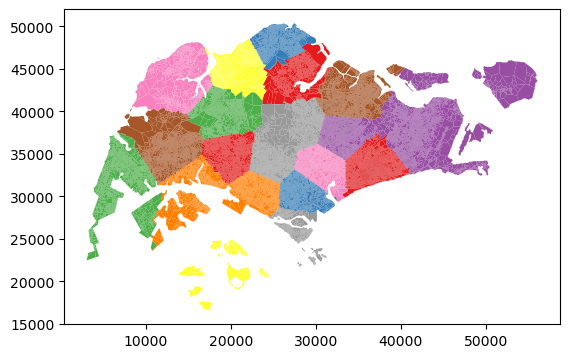

In [32]:
# Specify the column to use for color and colormap
column = 'cluster'
cmap = 'Set1'

# Plot the GeoDataFrame with colors determined by the 'cluster' column
tessellation.plot(column=column, cmap=cmap)

In [33]:
# import matplotlib.pyplot as plt

# gdf_cluster_4 = tessellation.loc[tessellation['cluster'] == 3]
# # iterate over rows of the GeoDataFrame
# for idx, row in gdf_cluster_4.iterrows():
#     # create a new plot for each row
#     fig, ax = plt.subplots(figsize=(5,5))
#     row_gdf = gpd.GeoDataFrame([row], geometry='geometry', crs=gdf_cluster_4.crs)
#     # plot the row and set the title
#     row_gdf.plot(ax=ax)
#     ax.set_title(f"uID: {row['uID']}")
    
#     # show the plot
#     plt.show()

In [37]:
duplicates(tessellation)

# Perform a spatial join on the tessellation data
overlapping_polygons = gpd.sjoin(tessellation, tessellation, op='intersects')

# Print any overlapping polygons
if len(overlapping_polygons) > 0:
    print("The following polygons in the tessellation overlap:")
    print(overlapping_polygons)
else:
    print("No overlapping polygons found in the tessellation.")

/home/virgilxw/miniconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


The following polygons in the tessellation overlap:
         uID_left                                           geometry  \
0             0.0  POLYGON ((18593.965 36751.429, 18594.904 36752...   
14373     14374.0  POLYGON ((18666.446 36612.896, 18661.487 36617...   
14728     14729.0  POLYGON ((18756.288 36701.740, 18756.291 36701...   
92205     92216.0  POLYGON ((18601.154 36585.386, 18600.301 36585...   
116660  5004190.0  POLYGON ((18601.498 36719.537, 18590.959 36727...   
...           ...                                                ...   
122484  5010014.0  POLYGON ((8264.735 40063.833, 8257.091 40033.0...   
122485  5010015.0  POLYGON ((8060.902 39290.495, 8035.428 39262.7...   
122486  5010016.0  POLYGON ((19023.455 22926.454, 18974.206 22926...   
122487  5010017.0  POLYGON ((18727.116 22922.232, 18727.115 22895...   
122488  5010018.0  POLYGON ((17830.274 17459.007, 17851.500 17398...   

        eID_left  cluster_left  index_right  uID_right  eID_right  \
0           66

In [35]:
[for region, df_region_cluster in tessellation.groupby('cluster')]

              uID                                           geometry    eID  \
0             0.0  POLYGON ((18593.965 36751.429, 18594.904 36752...   6692   
34           34.0  MULTIPOLYGON (((18206.037 35300.642, 18213.872...   5609   
35           35.0  POLYGON ((18474.511 34459.693, 18476.511 34458...   7297   
36           36.0  POLYGON ((17725.810 35021.079, 17726.815 35022...   7272   
37           37.0  POLYGON ((17968.821 34817.258, 17968.545 34816...   7280   
...           ...                                                ...    ...   
122297  5009827.0  POLYGON ((17770.402 34934.975, 17784.491 34922...  13131   
122356  5009886.0  POLYGON ((19878.142 33475.779, 19873.412 33480...  13196   
122456  5009986.0  POLYGON ((19864.582 33294.890, 19870.625 33300...  13426   
122460  5009990.0  POLYGON ((19908.907 33247.784, 19922.418 33235...  13431   
122461  5009991.0  POLYGON ((19894.983 33194.200, 19921.547 33165...  13433   

        cluster  
0             0  
34            0

In [36]:
# Assume `gdf` is a GeoDataFrame
tessellation_grouped = tessellation.groupby('cluster')
print(tessellation_grouped)

In [61]:
print(tessellation_grouped)

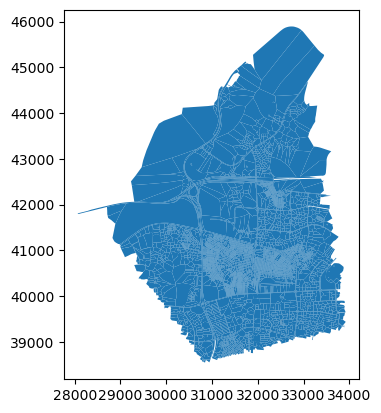

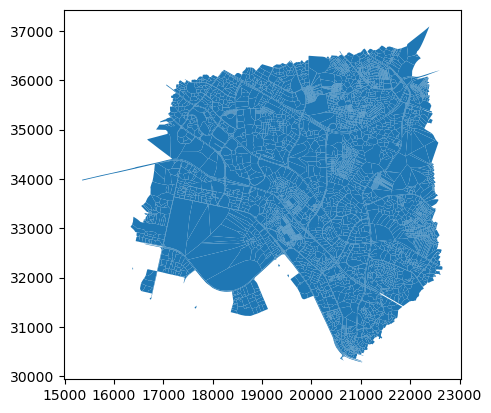

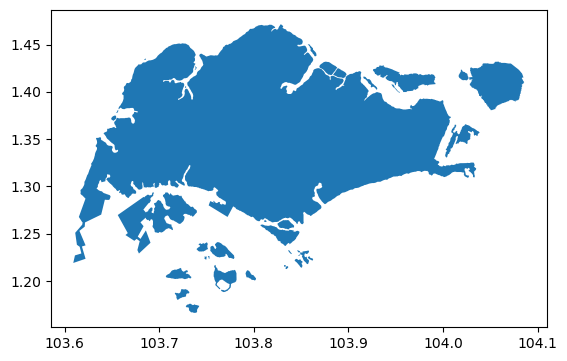

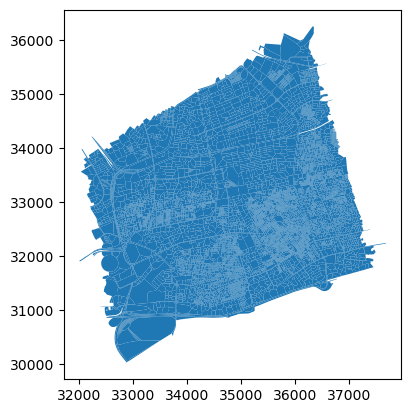

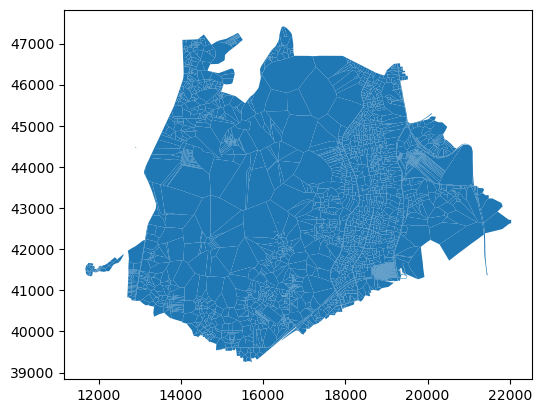

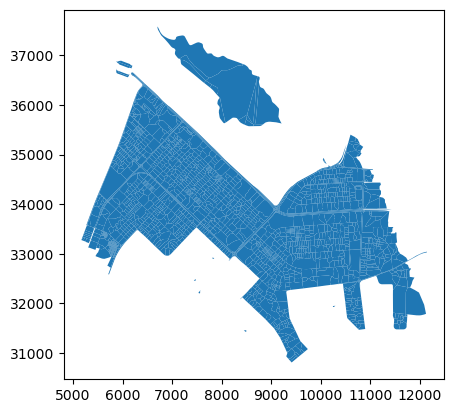

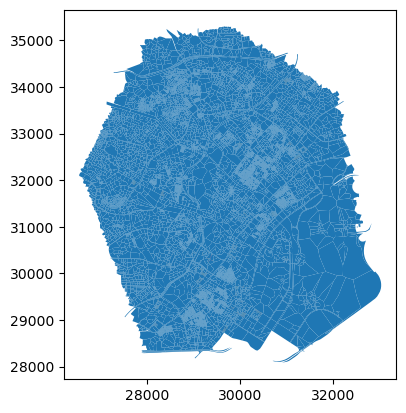

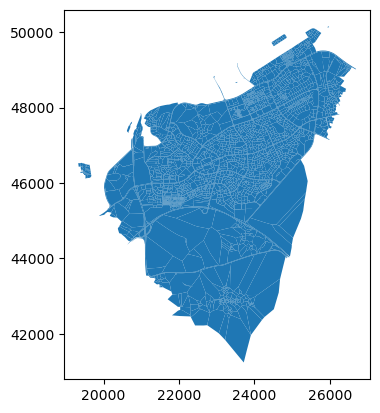

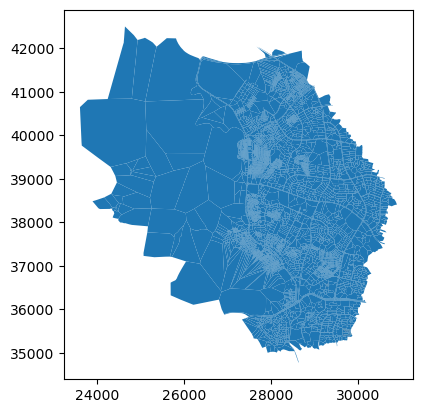

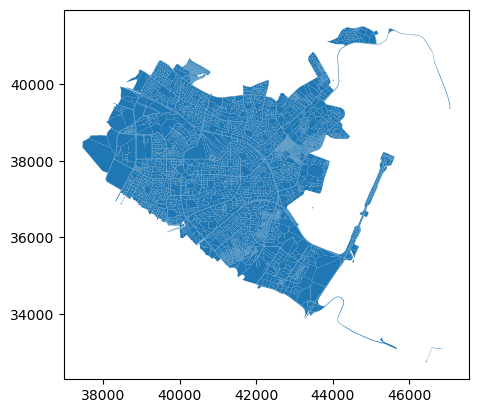

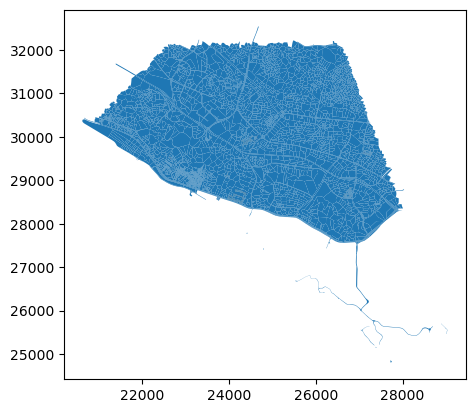

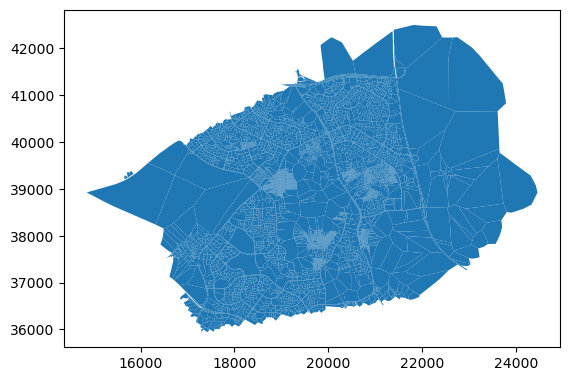

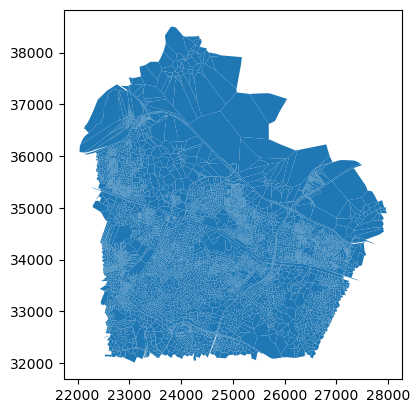

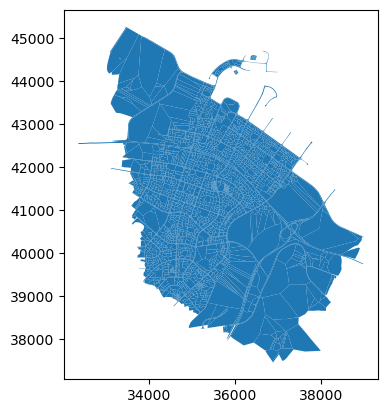

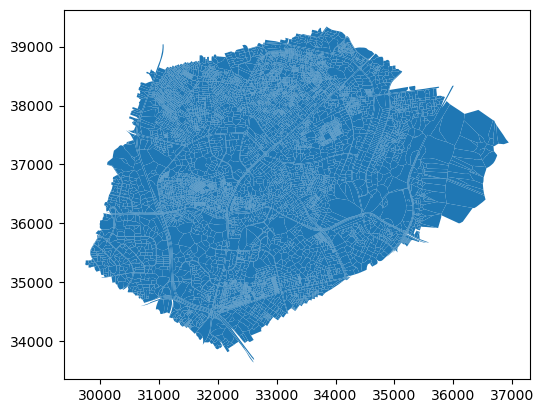

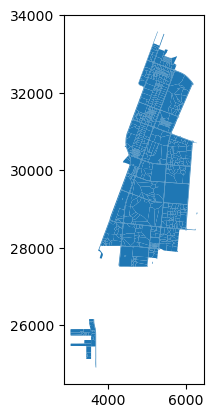

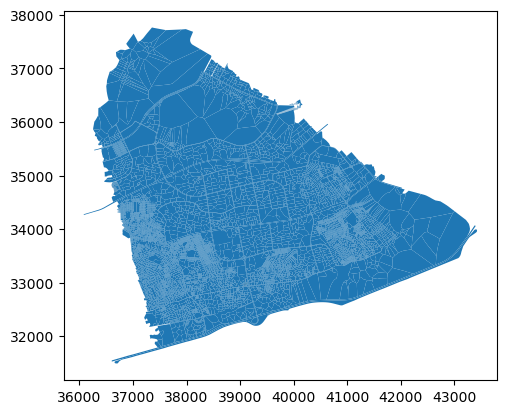

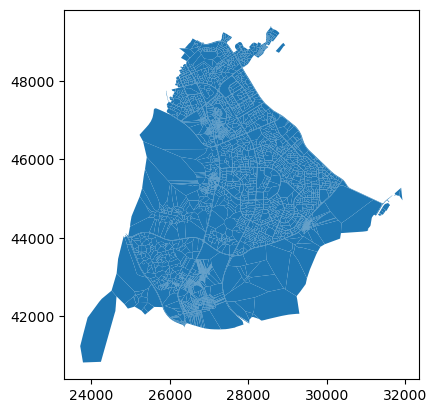

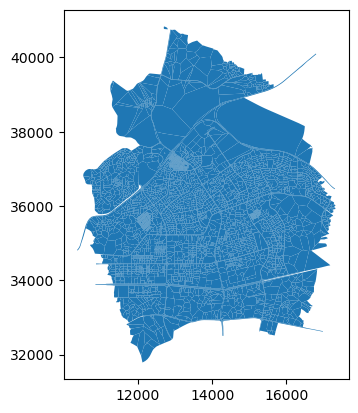

In [58]:
for key in tessellation_separate:
    tessellation_separate[key].plot()

In [56]:
overlapping_rows = overlapping_rows.compute()
# If any overlapping rows are found, print their uid
if len(overlapping_rows) > 0:
    print("The following rows in dask_tessellation overlap with each other:")
    print(overlapping_rows)
else:
    print("There are no overlapping rows in dask_tessellation.")

The following rows in dask_tessellation overlap with each other:
          uID_left  eID_left  \
cluster                        
11             0.0      6685   
18             1.0      3225   
1             34.0      5602   
10            95.0       965   
12           336.0      2667   
...            ...       ...   
10            95.0       965   
12           336.0      2667   
5             32.0      7012   
15          9726.0      7443   
2        5009990.0     13389   

                                                  geometry  index_right  \
cluster                                                                   
11       MULTIPOLYGON (((17292.314 35983.796, 17292.377...            1   
18       MULTIPOLYGON (((11708.115 32799.853, 11707.120...            1   
1        MULTIPOLYGON (((17672.114 31424.709, 17665.090...            1   
10       MULTIPOLYGON (((22021.549 29432.267, 22017.678...            1   
12       POLYGON ((22739.021 32142.261, 22737.860 32142...          

In [ ]:

# Plot the GeoDataFrame with colors determined by the 'cluster' column
for n in range(n_clusters):
    cluster.loc[[n]].plot()

In [ ]:
Daskcluster.close()
client.shutdown()

In [ ]:
cluster.to_parquet("./out/singapore/clusters.pq")

In [ ]:
file_pattern = "./out/singapore/tess_chunk_*.pq"
file_list = glob.glob(file_pattern)

for file_path in file_list:
    os.remove(file_path)

for key in tessellation_separate:
    out = tessellation_separate[key]
    print(duplicates(out))
    out.to_parquet("./out/singapore/tess_chunk_"+str(key)+".pq")

In [ ]:
includes_dict = dict()
for i in range(n_clusters):
    includes_dict[i] = []

for index, row in tqdm(tessellation.iterrows(), total=tessellation.shape[0]):
    
    includes_dict[row["cluster"]].append(row["uID"])

os.remove("./out/singapore/clustertess.json")

with open('./out/singapore/clustertess.json', 'w') as f:
    json.dump(includes_dict, f)